In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [13]:
# lag1과 lag7 기반 파생 변수 생성 후 다시 학습 및 예측 수행

# 원본 데이터 로딩 및 정리
df = pd.read_csv("cabbage_HIGH_2020to2025_JanToMay.csv")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)
df['target'] = df['avg_price'].shift(-1)

# lag 변수 생성 (1일, 2일, 3일, 7일)
for lag in [1, 2, 3, 7]:
    df[f'avg_price_lag{lag}'] = df['avg_price'].shift(lag)
    df[f'intake_lag{lag}'] = df['intake'].shift(lag)
    df[f'gap_lag{lag}'] = df['gap'].shift(lag)

# 파생 변수: 변화율 (lag1 대비), 7일 평균과 차이
df['avg_price_change_lag1'] = df['avg_price'] / df['avg_price_lag1'] - 1
df['intake_change_lag1'] = df['intake'] / df['intake_lag1'] - 1
df['price_ma7_diff'] = df['avg_price'] - df['avg_price_lag7']

# 캘린더 피처
df['weekday'] = df['date'].dt.weekday
df = df.dropna().copy()

# 훈련/테스트 분리
train_df = df[(df['year'] < 2025) | ((df['year'] == 2025) & (df['month'] < 5))]
test_df = df[(df['year'] == 2025) & (df['month'] == 5)]

# 피처 선택
feature_cols = [col for col in df.columns if ('lag' in col or 'change' in col or 'diff' in col or col == 'weekday') and 'target' not in col]
X_train, y_train = train_df[feature_cols], train_df['target']
X_test, y_test = test_df[feature_cols], test_df['target']

# 모델 훈련
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 결과 정리
result_df = test_df[['date', 'avg_price']].copy()
result_df['predicted_price'] = y_pred
result_df['actual_price'] = y_test.values


rmse


1096.9958187727107

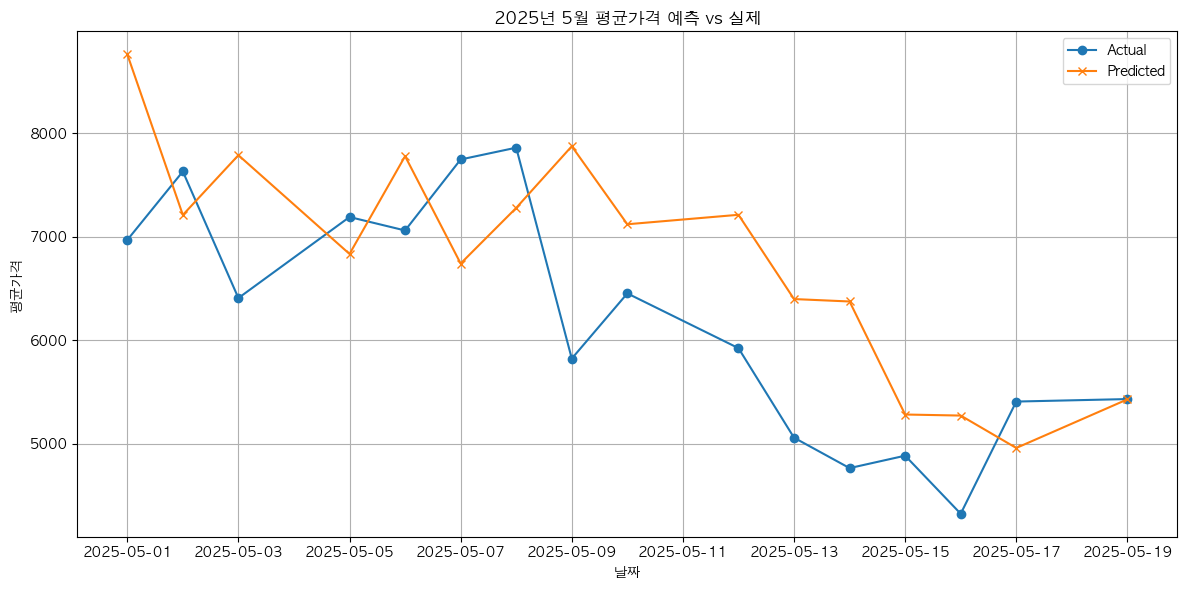

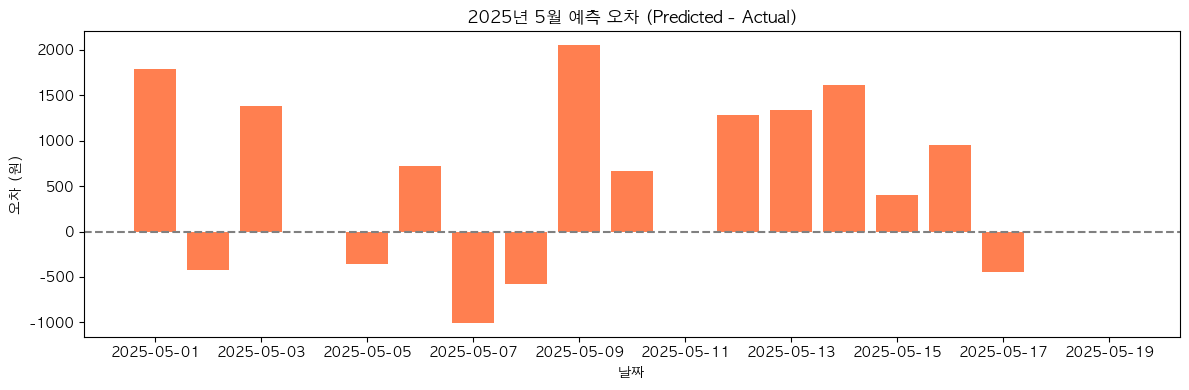

In [12]:
# 예측값과 실제값 비교 시각화
import matplotlib.pyplot as plt

# 시계열 형태로 정렬
result_df_sorted = result_df.sort_values('date')

# 1. 예측 vs 실제 시계열 비교
plt.figure(figsize=(12, 6))
plt.plot(result_df_sorted['date'], result_df_sorted['actual_price'], label='Actual', marker='o')
plt.plot(result_df_sorted['date'], result_df_sorted['predicted_price'], label='Predicted', marker='x')
plt.title("2025년 5월 평균가격 예측 vs 실제")
plt.xlabel("날짜")
plt.ylabel("평균가격")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 오차 시각화 (예측 - 실제)
result_df_sorted['error'] = result_df_sorted['predicted_price'] - result_df_sorted['actual_price']
plt.figure(figsize=(12, 4))
plt.bar(result_df_sorted['date'], result_df_sorted['error'], color='coral')
plt.axhline(0, color='gray', linestyle='--')
plt.title("2025년 5월 예측 오차 (Predicted - Actual)")
plt.xlabel("날짜")
plt.ylabel("오차 (원)")
plt.tight_layout()
plt.show()


In [15]:
# 필요한 모듈 임포트
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("cabbage_HIGH_2020to2025_JanToMay.csv")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

# 요일 피처 생성
df['weekday'] = df['date'].dt.weekday  # 월:0 ~ 일:6
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# 일요일(avg_price) 0으로 처리
df.loc[df['weekday'] == 6, 'avg_price'] = 0

# 타겟 설정: 다음날 평균가격
df['target'] = df['avg_price'].shift(-1)

# 시계열 피처 생성 (lag + 변화율 + 차이)
for lag in [1, 2, 3, 7]:
    df[f'avg_price_lag{lag}'] = df['avg_price'].shift(lag)
    df[f'intake_lag{lag}'] = df['intake'].shift(lag)
    df[f'gap_lag{lag}'] = df['gap'].shift(lag)

df['avg_price_change_lag1'] = df['avg_price'] / df['avg_price_lag1'] - 1
df['intake_change_lag1'] = df['intake'] / df['intake_lag1'] - 1
df['price_ma7_diff'] = df['avg_price'] - df['avg_price_lag7']

# 결측 제거
df = df.dropna().copy()

# 훈련/테스트 데이터 분리 (2025년 5월 예측)
train_df = df[(df['year'] < 2025) | ((df['year'] == 2025) & (df['month'] < 5))]
test_df = df[(df['year'] == 2025) & (df['month'] == 5)]

# 피처 컬럼 정의
feature_cols = [col for col in df.columns if (
    'lag' in col or 'change' in col or 'diff' in col or col in ['weekday', 'is_weekend']
) and 'target' not in col]

X_train, y_train = train_df[feature_cols], train_df['target']
X_test, y_test = test_df[feature_cols], test_df['target']

# 모델 훈련
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 결과 정리
result_df = test_df[['date', 'avg_price']].copy()
result_df['predicted_price'] = y_pred
result_df['actual_price'] = y_test.values
result_df['error'] = result_df['predicted_price'] - result_df['actual_price']

rmse


1098.6429957959176

In [18]:
# 필요한 모듈 임포트
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("cabbage_HIGH_2020to2025_JanToMay.csv")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

# 요일 피처 생성
df['weekday'] = df['date'].dt.weekday  # 월:0 ~ 일:6
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# 일요일(avg_price) 0으로 처리
df.loc[df['weekday'] == 6, 'avg_price'] = 0

# 타겟 설정: 다음날 평균가격
df['target'] = df['avg_price'].shift(-1)

# 시계열 피처 생성 (lag + 변화율 + 차이)
for lag in [1, 2, 3, 7]:
    df[f'avg_price_lag{lag}'] = df['avg_price'].shift(lag)
    df[f'intake_lag{lag}'] = df['intake'].shift(lag)
    df[f'gap_lag{lag}'] = df['gap'].shift(lag)

df['avg_price_change_lag1'] = df['avg_price'] / df['avg_price_lag1'] - 1
df['intake_change_lag1'] = df['intake'] / df['intake_lag1'] - 1
df['price_ma7_diff'] = df['avg_price'] - df['avg_price_lag7']

# 결측 제거
df = df.dropna().copy()

# 훈련/테스트 데이터 분리 (2025년 5월 예측)
train_df = df[(df['year'] < 2025) | ((df['year'] == 2025) & (df['month'] < 5))]
test_df = df[(df['year'] == 2025) & (df['month'] == 5)]

# 피처 컬럼 정의
feature_cols = [col for col in df.columns if (
    'lag' in col or 'change' in col or 'diff' in col or col in ['weekday', 'is_weekend']
) and 'target' not in col]

X_train, y_train = train_df[feature_cols], train_df['target']
X_test, y_test = test_df[feature_cols], test_df['target']

# 모델 훈련
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 결과 정리
result_df = test_df[['date', 'avg_price']].copy()
result_df['predicted_price'] = y_pred
result_df['actual_price'] = y_test.values
result_df['error'] = result_df['predicted_price'] - result_df['actual_price']


rmse


1098.6429957959176

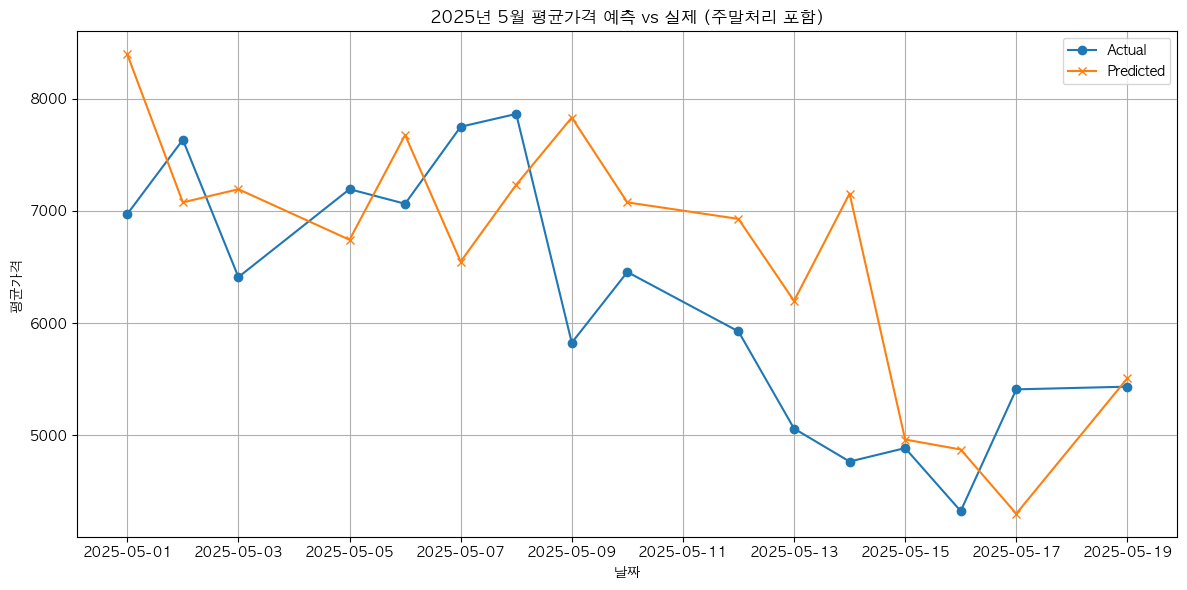

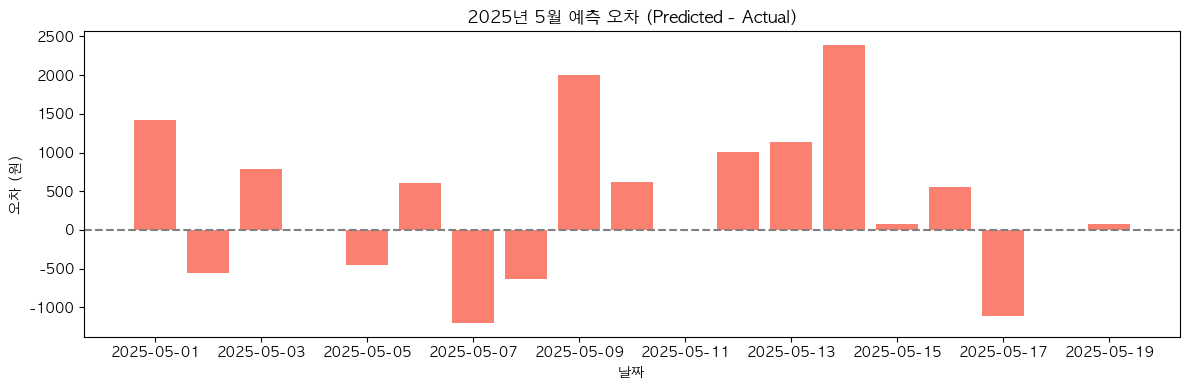

In [19]:
# 학습량 줄이지 않고 시각화만 수행
# 시계열 시각화: 예측 vs 실제
result_df_sorted = result_df.sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(result_df_sorted['date'], result_df_sorted['actual_price'], label='Actual', marker='o')
plt.plot(result_df_sorted['date'], result_df_sorted['predicted_price'], label='Predicted', marker='x')
plt.title("2025년 5월 평균가격 예측 vs 실제 (주말처리 포함)")
plt.xlabel("날짜")
plt.ylabel("평균가격")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 오차 시각화
plt.figure(figsize=(12, 4))
plt.bar(result_df_sorted['date'], result_df_sorted['error'], color='salmon')
plt.axhline(0, color='gray', linestyle='--')
plt.title("2025년 5월 예측 오차 (Predicted - Actual)")
plt.xlabel("날짜")
plt.ylabel("오차 (원)")
plt.tight_layout()
plt.show()
